In [35]:
library(randomForest)
library(glmnet)

In [2]:
wH=read.csv("../data/jasa_10_07_2023_data/Real estate.csv")
wH[1:4,]
dim(wH)

,No,X1.transaction.date,X2.house.age,X3.distance.to.the.nearest.MRT.station,X4.number.of.convenience.stores,X5.latitude,X6.longitude,Y.house.price.of.unit.area
,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,1,2012.917,32.0,84.87882,10,24.98298,121.5402,37.9
2,2,2012.917,19.5,306.59470,9,24.98034,121.5395,42.2
3,3,2013.583,13.3,561.98450,5,24.98746,121.5439,47.3
4,4,2013.500,13.3,561.98450,5,24.98746,121.5439,54.8


[1] 414   8

In [37]:
xs=as.matrix(wH[,3:7])
X=cbind(xs[,1:3],cos(xs[,4])*cos(xs[,5]),cos(xs[,4])*sin(xs[,5]),sin(xs[,4]))
Yfull=as.numeric(wH[,8])

s1=sample(1:nrow(X),nrow(X),replace=FALSE)
X=X[s1,]
Ye=Yfull[s1]
nfull=nrow(X)

In [39]:
nrow(X)
length(Ye)
dim(X)

nfull=nrow(X)

[1] 414

[1] 414

[1] 414   6

In [44]:
#with random forest
set.seed(123)
reps=1:25
rho=seq(0,2,0.1)
MC=matrix(0,nrow=ncol(X),ncol=length(rho))
MC_n=matrix(0,nrow=ncol(X),ncol=length(rho))

RS1=matrix(0,nrow=ncol(X),ncol=length(rho))
RS2=matrix(0,nrow=ncol(X),ncol=length(rho))


trsize=114
tesize=200

for(rep in reps)
    {
sn1=sample(1:nrow(X),trsize+tesize,replace=FALSE)
sam1=sn1[1:trsize]
Xtr=X[sam1,]
Y=Ye[sam1]
tr=as.data.frame(cbind(Y,Xtr))

sam2=sn1[(trsize+1):(trsize+tesize)]
Xte=X[sam2,]
Y=Ye[sam2]
te=as.data.frame(cbind(Y,Xte))

size=tesize
split=3
K=size/split

fit=lm(Y~.,tr)
yh=predict(fit,te)
S=abs(yh-te[,1])
Q_90=quantile(S[1:K],0.9)

Ste=S[(K+1):size]
indic=as.factor(as.numeric(Ste>Q_90))
# Xte=te[(K+1):size,2:5]
ten=te[(K+1):size,]

Xval=X[-sn1,]
Yval=Ye[-sn1]
val=as.data.frame(cbind(Yval,Xval))
    
sens_rho=matrix(0,nrow=split-1,ncol=length(rho))

k=1

Var=2:(ncol(tr))
for(var in Var)
    {
for(i in 0:(split-2))
    {
    
    index=1:(size-K)
    index1=index[-(((K*i)+1):(K*(i+1)))]
    index2=index[(((K*i)+1):(K*(i+1)))]
 newtr=as.data.frame(cbind(as.factor(indic[index1]),ten[index1,var]))
 colnames(newtr)=c("I","V1")

    
    pf=randomForest(as.factor(I)~.,newtr,ntree=100,nodesize=50,importance=TRUE,
                        proximity=TRUE)
    

    
     xxx=as.data.frame(cbind(ten[index2,var],ten[index2,var]^2))
 
    colnames(xxx)=c("V1","X12")
    p2=predict(pf, xxx, type = "prob")[,2]

#       xxx=as.data.frame(cbind(tX[,var-1],tX[,var-1]^2))
#       colnames(xxx)=c("V1","X12")
#      etap=predict(pf, xxx, type = "prob")[,2]
    

    k=1
    for(r in rho)
    {
    
#      eta=quantile(etap,1-exp(-r))
    
       eta=quantile(p2,1-exp(-r))
     d1=p2-eta
#     pindf=which(d1>0)
#     d2=mean(p2[pindf])
    d1=d1*(d1>0)
    d2=exp(r)*d1+eta
    d3=exp(r)*(as.numeric(p2>eta))*(as.numeric(indic[index2])-1-p2)

        sens_rho[(i+1),k]=mean(d2)+mean(d3)
        

        
       k=k+1
    
    
    
}
 
    }
    
       sens=colMeans(sens_rho)
    
   
    MCM=sens
    MCM=MCM-MCM[1]+0.1
    
    
    MC[var-1,]=MC[var-1,]+MCM
    
    sens_rho=matrix(0,nrow=split-1,ncol=length(rho))

    
        m=1
for(r in rho)
    {
      X_i=ten[,var]
    q1=quantile(X_i,1-exp(-r))
    q2=-quantile(-X_i,1-exp(-r))
    
    ind1=which(X_i>q1)
    ind2=which(X_i<=q2)
    
    indic1=(as.numeric(Ste[ind1]>Q_90))
    
    indic2=(as.numeric(Ste[ind2]>Q_90))
    
    RS1[var-1,m]=RS1[var-1,m]+mean(indic1)
#     RS1[var-1,k]=RS1[var-1,k]-RS1[var-1,1]+0.1
    
    RS2[var-1,m]=RS2[var-1,m]+mean(indic2)
#     RS2[var-1,k]=RS2[var-1,k]-RS2[var-1,1]+0.1
    m=m+1
    
    }
    
    
    }
}
MC=MC/length(reps)

RS1=RS1/length(reps)
RS2=RS2/length(reps)

In [45]:
MC

RS1

RS2

0.1,0.1033782,0.1071117,0.1112379,0.1157980,0.1194491,0.1248311,0.1302522,0.1362772,0.1420747,⋯,0.1514261,0.1608770,0.1661241,0.1700381,0.1661565,0.1682703,0.1718181,0.1674252,0.1760810,0.1794963
0.1,0.1020397,0.1042939,0.1067851,0.1095384,0.1125914,0.1148643,0.1184943,0.1225804,0.1268042,⋯,0.1304413,0.1337995,0.1406216,0.1412818,0.1408343,0.1402479,0.1427175,0.1374795,0.1335292,0.1344599
0.1,0.1023902,0.1050319,0.1079513,0.1111778,0.1147437,0.1176094,0.1212613,0.1239998,0.1288286,⋯,0.1328903,0.1378509,0.1340187,0.1372485,0.1392382,0.1389949,0.1220494,0.1237581,0.1310367,0.1337514
0.1,0.1017847,0.1037571,0.1059370,0.1083461,0.1110237,0.1134022,0.1159307,0.1191711,0.1221442,⋯,0.1240444,0.1257707,0.1189396,0.1219293,0.1173779,0.1138053,0.1116956,0.1111531,0.1115536,0.1119167
0.1,0.1014341,0.1030191,0.1047708,0.1067067,0.1088462,0.1112111,0.1120538,0.1116937,0.1129309,⋯,0.1100096,0.1121148,0.1061964,0.1021176,0.1018431,0.1004775,0.1040888,0.1050060,0.1040889,0.1058314
0.1,0.1026771,0.1056357,0.1089055,0.1125192,0.1136155,0.1168223,0.1212055,0.1260496,0.1292590,⋯,0.1379295,0.1421763,0.1426226,0.1456592,0.1506263,0.1569731,0.1644831,0.1648236,0.1684650,0.1740642


0.09258711,0.09679552,0.09998641,0.10658531,0.10679347,0.10546484,0.11023217,0.11635023,0.11735290,0.12316347,⋯,0.13072486,0.14007692,0.15123810,0.15912879,0.15875862,0.16222222,0.16733333,0.16320346,0.16284211,0.16797386
0.10133703,0.10054665,0.09793022,0.09198912,0.08690547,0.08664198,0.08682841,0.08935344,0.09430898,0.09589529,⋯,0.08298097,0.08302564,0.06501961,0.06709066,0.06703448,0.06843305,0.07338551,0.08370563,0.09042105,0.10083333
0.09511429,0.09511429,0.09110417,0.09087148,0.09674588,0.09893321,0.09929620,0.10677415,0.11659117,0.12347409,⋯,0.11300348,0.10555374,0.10716734,0.11206795,0.11001093,0.11279724,0.11533118,0.11516890,0.10767817,0.09916188
0.10090909,0.10754321,0.10292646,0.10574753,0.11072617,0.11190836,0.11499711,0.11938506,0.12275706,0.12369317,⋯,0.11291755,0.11159784,0.10292810,0.09132576,0.07733333,0.05521823,0.05286667,0.04972294,0.05065497,0.05844771
0.10066158,0.10849100,0.11279307,0.10609485,0.11166037,0.11358829,0.11436531,0.11916703,0.12344828,0.11880342,⋯,0.10682875,0.10038462,0.08917460,0.08753788,0.07112644,0.06814815,0.06955652,0.06799134,0.06888889,0.07086601
0.09868080,0.09935922,0.10109072,0.10685173,0.11698028,0.12357627,0.12790715,0.12745921,0.13133333,0.13311511,⋯,0.13536998,0.13328205,0.12505696,0.12595186,0.11245977,0.11305755,0.12056190,0.14005772,0.14642105,0.15083333


0.1004511,0.09030854,0.08617848,0.08122449,0.08567867,0.08567299,0.08672715,0.08617208,0.08862753,0.08956499,⋯,0.08767940,0.08260976,0.08189189,0.08698752,0.08886022,0.09714286,0.09883077,0.10916996,0.10950649,0.11286550
0.1004511,0.09852667,0.10591159,0.11273770,0.10903415,0.10286175,0.10548942,0.11244229,0.11694377,0.11962482,⋯,0.12776021,0.12727642,0.11983539,0.11924905,0.11079386,0.10808594,0.11033043,0.11305665,0.12085714,0.12553049
0.1004511,0.10058944,0.09769909,0.09928666,0.09535673,0.09058694,0.09212612,0.09881142,0.10138783,0.10233052,⋯,0.10622813,0.11025111,0.11632116,0.12949493,0.13062231,0.13147853,0.12850846,0.12805924,0.13272414,0.12960867
0.1004511,0.10434986,0.11154629,0.10026799,0.09430212,0.08621688,0.08209552,0.08172773,0.08287996,0.08165031,⋯,0.07981994,0.07989277,0.08404390,0.08859558,0.09302010,0.09022952,0.08978136,0.08294071,0.06069264,0.05017544
0.1004511,0.10094826,0.10720267,0.10447330,0.09735331,0.08938272,0.08157078,0.08265304,0.08389928,0.08043076,⋯,0.07838333,0.08217341,0.08543465,0.08411171,0.07006835,0.05501587,0.04929231,0.04118577,0.03771429,0.03087719
0.1004511,0.09198283,0.09486646,0.09122243,0.08334582,0.08094080,0.07504628,0.07452736,0.06714754,0.06638185,⋯,0.06767994,0.07301726,0.08131305,0.08576623,0.09217320,0.09569312,0.10030769,0.09407115,0.09152381,0.09597661


In [18]:
dim(X)

[1] 414   6

In [26]:
RS1

RS2

0.03847529,0.04062809,0.04371324,0.04768996,0.05134161,0.05048462,0.05314520,0.04720734,0.05069724,0.05490997,⋯,0.05913989,0.06460183,0.07044289,0.07800117,0.08222222,0.08173469,0.08579281,0.09207692,0.09596825,0.10227273
0.04496748,0.04480457,0.04310855,0.04238119,0.03381677,0.03567711,0.03069583,0.03420991,0.03632399,0.03393225,⋯,0.02200633,0.01402464,0.01534936,0.01710234,0.01856098,0.02049320,0.02304228,0.02523898,0.02823173,0.03088343
0.04730226,0.04730226,0.04543860,0.04542922,0.04984910,0.05209932,0.05185332,0.05297989,0.06214633,0.06274181,⋯,0.05038799,0.03984806,0.03754203,0.04170496,0.04670823,0.04886029,0.04886029,0.03521284,0.02246592,0.00547619
0.04485356,0.04901894,0.04394629,0.04865562,0.05224870,0.04666310,0.05011277,0.05497861,0.05243715,0.04868305,⋯,0.04003797,0.03199889,0.02323660,0.01768556,0.01334731,0.01142857,0.01196819,0.01310256,0.01457516,0.01656950
0.04485356,0.04891876,0.05372796,0.04427986,0.04786806,0.05174825,0.04352648,0.04744488,0.04815507,0.04450663,⋯,0.04612923,0.03842008,0.02751748,0.01843366,0.01873031,0.02042517,0.02272727,0.02543590,0.02828338,0.03124218
0.04498265,0.04803258,0.04920670,0.04865307,0.05235182,0.05795612,0.06037474,0.06226516,0.06670820,0.05922265,⋯,0.06561671,0.06259870,0.06029287,0.03951113,0.03652368,0.03617709,0.03831277,0.04215385,0.04983799,0.05895392


0.04466667,0.03439077,0.03548534,0.03434065,0.03719682,0.03850365,0.03976621,0.04146049,0.03442944,0.03635135,⋯,0.03132204,0.03149924,0.03383085,0.03789942,0.04047475,0.04455830,0.048848485,0.05175610,0.053766398,0.056988032
0.04466667,0.04475725,0.04950587,0.05445269,0.05605245,0.05338159,0.05147870,0.05563596,0.06166468,0.05931791,⋯,0.06637790,0.06866240,0.06106494,0.05165676,0.04580795,0.04796927,0.051621320,0.05351792,0.049675627,0.049705229
0.04466667,0.04805602,0.04391107,0.04697878,0.04159566,0.03571396,0.03563217,0.03778066,0.03740325,0.03520203,⋯,0.03584763,0.03833851,0.04068620,0.04318343,0.04593161,0.04593161,0.042188296,0.03992452,0.033469147,0.031258526
0.04466667,0.04690949,0.05193441,0.05340542,0.04765754,0.04281604,0.03849425,0.03455765,0.03804785,0.04066526,⋯,0.02898148,0.03001119,0.03196690,0.03593709,0.03945923,0.04192426,0.048141829,0.05107733,0.021868184,0.014201002
0.04466667,0.04466024,0.04959184,0.05362250,0.04428504,0.04490316,0.04181135,0.04190829,0.04612605,0.03526925,⋯,0.03752815,0.04134466,0.04425373,0.04748383,0.03115565,0.01193292,0.004545455,0.00300000,0.003333333,0.003636364
0.04466667,0.04250322,0.04605646,0.04214441,0.03465636,0.03536869,0.02665072,0.02770710,0.02552158,0.02441995,⋯,0.02900503,0.03260377,0.03490289,0.03286426,0.02944444,0.02847347,0.024505051,0.01895122,0.017777778,0.017670996


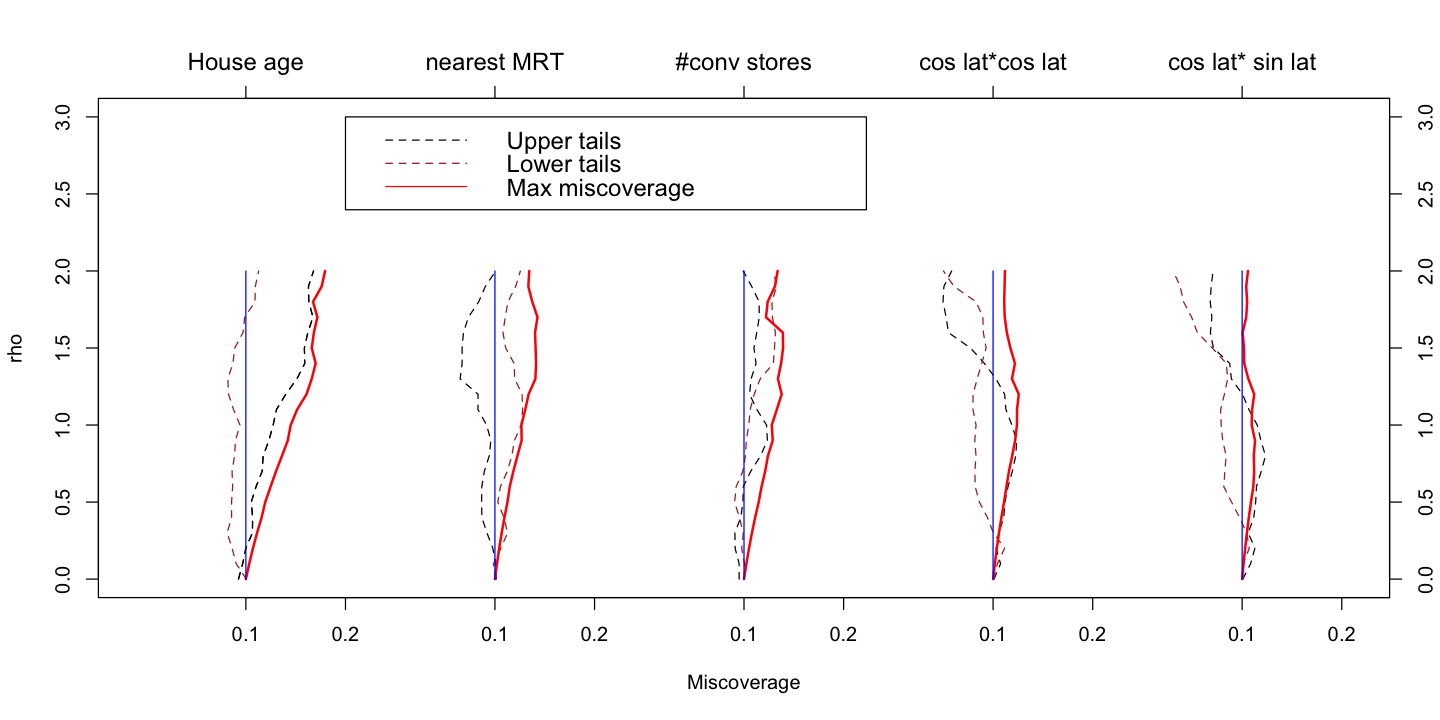

In [46]:
options(repr.plot.width=12, repr.plot.height=6)

inc=0.25
gh=1
thick_up_lo=2
type_of_rs=2

plot(RS1[gh,],rho,xlim=c(0,1.2),ylim=c(0,3),cex.axis=1,xaxt = "n",xlab="Miscoverage",lty=type_of_rs,ty='l')
att=c(0.1,0.2,0.1+inc,0.2+inc,0.1+2*inc,0.2+2*inc,0.1+3*inc,0.2+3*inc,0.1+4*inc,0.2+4*inc,0.1+5*inc,0.2+5*inc)
axis(side=1, at=att, cex.axis=1,labels=c(.1,.2,.1,.2,.1,.2,0.1,.2,.1,.2,.1,.2))



for(gh in 1:length(Var))
    {
    lines(RS1[gh,]+(gh-1)*inc,rho,lty=type_of_rs,ty='l')
lines(RS2[gh,]+(gh-1)*inc,rho,ty='l',lty=type_of_rs,col="brown")
lines(MC[gh,]+(gh-1)*inc,rho,ty='l',lwd=thick_up_lo,col="red")
    lines(c(0.1+(gh-1)*inc,0.1+(gh-1)*inc),c(0,2),ty='l',col="blue")
}
att=c(0.1,0.1+inc,0.1+2*inc,0.1+3*inc,0.1+4*inc,0.1+5*inc)
# axis(1, at=att, labels=c("Humidity","Wind Speed","Visibility","Pressure"))
axis(side=4,cex.axis=1)
axis(side=3, at=att,las=1, cex.lab=1.2,cex.axis=1.2, font=0.5,xlab="Variables", labels=c("House age","nearest MRT","#conv stores","cos lat*cos lat","cos lat* sin lat","sin lat"))

legend(0.2,3, legend=c("Upper tails", "Lower tails","Max miscoverage"),
       col=c("black", "brown","red","red"), lty=c(2,2,1,1), cex=1.2)